In [1]:
%matplotlib inline
import time
import random
from random import shuffle
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pickle
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import itertools
import logging

import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import transforms, datasets, models
from torchvision.datasets import CIFAR10

from scipy.stats import entropy, ks_2samp
from scipy.special import kl_div
from sklearn import metrics
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

import traceback
import copy
import os
import shutil

In [2]:
logname = 'logs/decentralized_multi_agent'
logging.basicConfig(filename=logname,
                            filemode='a',
                            format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                            datefmt='%H:%M:%S',
                            level=logging.DEBUG)

logging.info("Running Decentralized Learning test")

logger = logging.getLogger('Decentralized_log')

In [3]:
# reproduce randomness for fair comparison
np.random.seed(0)
torch.manual_seed(22)

LABELS

Excerpts from the paper:

    The HAM10000 Dataset: A Large Collection of Multi-Source Dermatoscopic Images of Common Pigmented Skin Lesions
    https://arxiv.org/abs/1803.10417

nv
Melanocytic nevi are benign neoplasms of melanocytes and appear in a myriad of variants, which all are included in our series. The variants may differ significantly from a dermatoscopic point of view.
[6705 images]

mel
Melanoma is a malignant neoplasm derived from melanocytes that may appear in different variants. If excised in an early stage it can be cured by simple surgical excision. Melanomas can be invasive or non-invasive (in situ). We included all variants of melanoma including melanoma in situ, but did exclude non-pigmented, subungual, ocular or mucosal melanoma.
[1113 images]

bkl
"Benign keratosis" is a generic class that includes seborrheic ker- atoses ("senile wart"), solar lentigo - which can be regarded a flat variant of seborrheic keratosis - and lichen-planus like keratoses (LPLK), which corresponds to a seborrheic keratosis or a solar lentigo with inflammation and regression [22]. The three subgroups may look different dermatoscop- ically, but we grouped them together because they are similar biologically and often reported under the same generic term histopathologically. From a dermatoscopic view, lichen planus-like keratoses are especially challeng- ing because they can show morphologic features mimicking melanoma [23] and are often biopsied or excised for diagnostic reasons.
[1099 images]

bcc
Basal cell carcinoma is a common variant of epithelial skin cancer that rarely metastasizes but grows destructively if untreated. It appears in different morphologic variants (flat, nodular, pigmented, cystic, etc) [21], which are all included in this set.
[514 images]

akiec
Actinic Keratoses (Solar Keratoses) and intraepithelial Carcinoma (Bowen’s disease) are common non-invasive, variants of squamous cell car- cinoma that can be treated locally without surgery. Some authors regard them as precursors of squamous cell carcinomas and not as actual carci- nomas. There is, however, agreement that these lesions may progress to invasive squamous cell carcinoma - which is usually not pigmented. Both neoplasms commonly show surface scaling and commonly are devoid of pigment. Actinic keratoses are more common on the face and Bowen’s disease is more common on other body sites. Because both types are in- duced by UV-light the surrounding skin is usually typified by severe sun damaged except in cases of Bowen’s disease that are caused by human papilloma virus infection and not by UV. Pigmented variants exists for Bowen’s disease [19] and for actinic keratoses [20]. Both are included in this set.
[327 images]

vasc
Vascular skin lesions in the dataset range from cherry angiomas to angiokeratomas [25] and pyogenic granulomas [26]. Hemorrhage is also included in this category.
[142 images]

df
Dermatofibroma is a benign skin lesion regarded as either a benign proliferation or an inflammatory reaction to minimal trauma. It is brown often showing a central zone of fibrosis dermatoscopically [24].
[115 images]


[Total images = 10015]


In [ ]:
# Create a new directory
base_dir = '../data/skin_cancer_mnist/base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 7 folders inside 'base_dir':

# train_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df
 
# val_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)



# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)

In [ ]:
df_data = pd.read_csv('../data/skin_cancer_mnist/HAM10000_metadata.csv')

df_data.head()

In [ ]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

In [ ]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

In [ ]:
df_data['duplicates'].value_counts()

In [ ]:
# now we filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

In [ ]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.30, random_state=24, stratify=y)

df_val.shape

In [ ]:
df_val['dx'].value_counts()

In [ ]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

In [ ]:
brain_df = pd.read_csv('../data/brain_tumor.csv',usecols=[0,1])
brain_df.head()

In [ ]:
df_train['dx'].value_counts()

In [ ]:
df_val['dx'].value_counts()

In [ ]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [ ]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('../data/skin_cancer_mnist/ham10000_images_part_1')
folder_2 = os.listdir('../data/skin_cancer_mnist/ham10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../data/skin_cancer_mnist/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../data/skin_cancer_mnist/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../data/skin_cancer_mnist/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../data/skin_cancer_mnist/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [ ]:
# note that we are not augmenting class 'nv'
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = '../data/skin_cancer_mnist/aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('../data/skin_cancer_mnist/base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('../data/skin_cancer_mnist/base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = '../data/skin_cancer_mnist/base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 5380 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('../data/skin_cancer_mnist/aug_dir')

In [ ]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None) # titles=labels will display the image labels



In [ ]:
print(len(os.listdir('../data/skin_cancer_mnist/base_dir/train_dir/nv')))
print(len(os.listdir('../data/skin_cancer_mnist/base_dir/train_dir/mel')))
print(len(os.listdir('../data/skin_cancer_mnist/base_dir/train_dir/bkl')))
print(len(os.listdir('../data/skin_cancer_mnist/base_dir/train_dir/bcc')))
print(len(os.listdir('../data/skin_cancer_mnist/base_dir/train_dir/akiec')))
print(len(os.listdir('../data/skin_cancer_mnist/base_dir/train_dir/vasc')))
print(len(os.listdir('../data/skin_cancer_mnist/base_dir/train_dir/df')))

In [ ]:
print(len(os.listdir('../data/skin_cancer_mnist/base_dir/val_dir/nv')))
print(len(os.listdir('../data/skin_cancer_mnist/base_dir/val_dir/mel')))
print(len(os.listdir('../data/skin_cancer_mnist/base_dir/val_dir/bkl')))
print(len(os.listdir('../data/skin_cancer_mnist/base_dir/val_dir/bcc')))
print(len(os.listdir('../data/skin_cancer_mnist/base_dir/val_dir/akiec')))
print(len(os.listdir('../data/skin_cancer_mnist/base_dir/val_dir/vasc')))
print(len(os.listdir('../data/skin_cancer_mnist/base_dir/val_dir/df')))

# Actual code starts here

In [4]:
# Standard transformations for improving CIFAR10. 

# Transformations A
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(220, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Transformations B
RC   = transforms.RandomCrop(220, padding=4)
RHF  = transforms.RandomHorizontalFlip()
RVF  = transforms.RandomVerticalFlip()
NRM  = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
TT   = transforms.ToTensor()
TPIL = transforms.ToPILImage()

# Transforms object for trainset with augmentation
transform_with_aug = transforms.Compose([TPIL, RC, RHF, RVF, TT, NRM])
# Transforms object for testset with NO augmentation
transform_no_aug   = transforms.Compose([TT, NRM])

transform_pil = transforms.Compose([TPIL, TT, NRM])

# Loading skin cancer mnist data
trainset = datasets.ImageFolder('../data/skin_cancer_mnist/base_dir/train_dir')
testset = datasets.ImageFolder('../data/skin_cancer_mnist/base_dir/val_dir')

classDict = {'akiec':0, 'bcc':1, 'bkl':2, 'df':3, 'mel':4, 'vasc':6}

# Define a function to separate CIFAR classes by class index

def get_class_i(x, y, i):
    """
    x: trainset.train_data or testset.test_data
    y: trainset.train_labels or testset.test_labels
    i: class label, a number between 0 to 9
    return: x_i
    """
    # Convert to a numpy array
    y = np.array(y)
    # Locate position of labels that equal to i
    pos_i = np.argwhere(y == i)
    # Convert the result into a 1-D list
    pos_i = list(pos_i[:,0])
    # Collect all data that match the desired label
    x_i = [x[j] for j in pos_i]
    
    return x_i

class DatasetMaker(Dataset):
    def __init__(self, datasets, transformFunc = transform_with_aug):
        """
        datasets: a list of get_class_i outputs, i.e. a list of list of images for selected classes
        """
        self.datasets = datasets
        self.lengths  = [len(d) for d in self.datasets]
        self.transformFunc = transformFunc
    def __getitem__(self, i):
        class_label, index_wrt_class = self.index_of_which_bin(self.lengths, i)
        img = self.datasets[class_label][index_wrt_class]
        img = self.transformFunc(img)
        return img, class_label

    def __len__(self):
        return sum(self.lengths)
    
    def index_of_which_bin(self, bin_sizes, absolute_index, verbose=False):
        """
        Given the absolute index, returns which bin it falls in and which element of that bin it corresponds to.
        """
        # Which class/bin does i fall into?
        accum = np.add.accumulate(bin_sizes)
        if verbose:
            print("accum =", accum)
        bin_index  = len(np.argwhere(accum <= absolute_index))
        if verbose:
            print("class_label =", bin_index)
        # Which element of the fallent class/bin does i correspond to?
        index_wrt_class = absolute_index - np.insert(accum, 0, 0)[bin_index]
        if verbose:
            print("index_wrt_class =", index_wrt_class)

        return bin_index, index_wrt_class

==> Preparing data..


In [5]:
trainset.classes

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [6]:
# Separating trainset/testset data/label
x_train  = [np.array(trainset[i][0].resize((224,224))) for i in range(len(trainset))]#.reshape(-1,32,32,3)
x_test = [np.array(testset[i][0].resize((224,224))) for i in range(len(testset))]#.reshape(-1,450,600,3)
y_train  = np.array(trainset.targets)
y_test   = np.array(testset.targets)

In [7]:
x_train = np.array(x_train)
x_test = np.array(x_test)

In [8]:
# If we are saving a fraction of random data to be used in training
frac = int(len(x_train) * 0.05)
choice = np.random.choice(len(x_train), frac)

x_reserve = x_train[choice]
y_reserve = y_train[choice]
x_train = np.delete(x_train,choice,axis=0)
y_train =np.delete(y_train,choice,axis=0)

In [9]:
# ================== Usage ================== #

# 
trainset1 = \
    DatasetMaker(
        [[], 
         get_class_i(x_train, y_train, classDict['bcc']),
         [],[],
         get_class_i(x_train, y_train, classDict['mel']),[]],
        transform_with_aug
    )
trainset2 = \
    DatasetMaker(
        [[],[],
         get_class_i(x_train, y_train, classDict['bkl']), 
         get_class_i(x_train, y_train, classDict['df']), 
         [],[]],
        transform_with_aug
    )
trainset3 = \
    DatasetMaker(
        [get_class_i(x_train, y_train, classDict['akiec']),
         [],[],[],[], 
         get_class_i(x_train, y_train, classDict['vasc'])],
        transform_with_aug
    )

#['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
trainset4 = \
    DatasetMaker(
        [get_class_i(x_train, y_train, classDict['akiec']), 
         get_class_i(x_train, y_train, classDict['bcc']), 
         get_class_i(x_train, y_train, classDict['bkl']), 
         get_class_i(x_train, y_train, classDict['df']), 
         get_class_i(x_train, y_train, classDict['mel']), 
         get_class_i(x_train, y_train, classDict['vasc'])],
        transform_with_aug
    )
reserved = \
    DatasetMaker(
        [get_class_i(x_reserve, y_reserve, classDict['akiec']), 
         get_class_i(x_reserve, y_reserve, classDict['bcc']), 
         get_class_i(x_reserve, y_reserve, classDict['bkl']), 
         get_class_i(x_reserve, y_reserve, classDict['df']), 
         get_class_i(x_reserve, y_reserve, classDict['mel']),
         get_class_i(x_reserve, y_reserve, classDict['vasc'])],
        transform_with_aug
    )
testset  = \
    DatasetMaker(
        [get_class_i(x_test, y_test, classDict['akiec']), 
         get_class_i(x_test, y_test, classDict['bcc']), 
         get_class_i(x_test, y_test, classDict['bkl']), 
         get_class_i(x_test, y_test, classDict['df']), 
         get_class_i(x_test, y_test, classDict['mel']),
         get_class_i(x_test, y_test, classDict['vasc'])],
        transform_no_aug
    )

superset = torch.utils.data.ConcatDataset([trainset3,reserved])
supersetA = torch.utils.data.ConcatDataset([trainset1,reserved])
supersetB = torch.utils.data.ConcatDataset([trainset2,reserved])

kwargs = {'num_workers': 2, 'pin_memory': False}

# Create datasetLoaders from trainset and testset
trainsetLoader1   = DataLoader(trainset1, batch_size=32, shuffle=True , **kwargs)
trainsetLoader2   = DataLoader(trainset2, batch_size=32, shuffle=True , **kwargs)
trainsetLoader3   = DataLoader(trainset3, batch_size=32, shuffle=True , **kwargs)
trainsetLoader4   = DataLoader(trainset4, batch_size=32, shuffle=True , **kwargs)
reservedLoader    = DataLoader(superset, batch_size=32, shuffle=True , **kwargs)
reservedLoaderA   = DataLoader(supersetA, batch_size=32, shuffle=True , **kwargs)
reservedLoaderB   = DataLoader(supersetB, batch_size=32, shuffle=True , **kwargs)
testsetLoader     = DataLoader(testset , batch_size=32, shuffle=False, **kwargs)

In [ ]:
def imshow(img):
    img = img / 2 + 0.3    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#### Test that things are working

W0430 08:27:38.034254 140576599361280 image.py:663] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


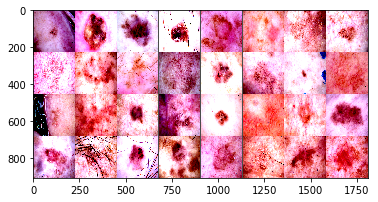

In [ ]:
img, label = next(iter(testsetLoader))
imshow(torchvision.utils.make_grid(img))

In [ ]:
img.shape

torch.Size([32, 3, 224, 224])

#### Decide on a GPU to use

In [ ]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
# device = 'cpu'
print(device)

# device2 = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

cuda:1


# Decentralized Pairwise Knowledge Transfer

## Define models used in knowledge transfer

In [ ]:
def kaiming_init(m):
    if isinstance(m, (torch.nn.Linear)):
        torch.nn.init.sparse_(m.weight, sparsity=0.33)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (torch.nn.Conv2d)):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)

class Decenter(torch.nn.Module):

    def __init__(self, shape):
        super(Decenter, self).__init__()
        if len(shape) == 1:
            shape = shape[0]
            self.dim = 0
        elif len(shape) == 2:
            shape = shape[1]
            self.dim = 1
        self.translation = torch.nn.Sequential(
#             torch.nn.Tanh(),
            torch.nn.Linear(shape*3, shape)
        )

#         self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, source1, source2, target):
        x = torch.cat((source1, source2, target), self.dim)
#         x = torch.cat((torch.flatten(source), torch.flatten(target)), 0)
#         x = torch.add(torch.flatten(source).to("cpu"), torch.flatten(target).to("cpu"))
        res = self.translation(x)
#         res = res.reshape(target.shape)
        return res
    
    
class Interpolate(torch.nn.Module):
    def __init__(self, size, mode):
        super(Interpolate, self).__init__()
        self.interp = torch.nn.functional.interpolate
        self.size = size
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, size=self.size, mode=self.mode, align_corners=False)
        return x
    
class Reshape(torch.nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
    
class Decenter_pooled(torch.nn.Module):

    def __init__(self, shape):
        super(Decenter_pooled, self).__init__()
        self.shape = shape
        self.translation = torch.nn.Sequential(
#             torch.nn.BatchNorm2d(channels_out),
#             torch.nn.AdaptiveAvgPool2d(1),
            Interpolate(size=1, mode='bilinear'),
            Reshape(shape[0], shape[1]*2),
            torch.nn.Linear(shape[1]*2, shape[1]*shape[-1]*shape[-1]),
#             Reshape(shape[0], shape[1] ,1 ,1),
        )

#         self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, source, target):
        x = torch.cat((source, target), 1)
        res = self.translation(x)
        res = res.view(self.shape[0], self.shape[1], self.shape[2], self.shape[3])
        return res
    
    
class Decenter_conv(torch.nn.Module):

    def __init__(self, shape):
        super(Decenter_conv, self).__init__()
        self.shape = shape
        channels_in = shape[1]*3
        channels_out = shape[1]
        self.translation = torch.nn.Sequential(
#             torch.nn.BatchNorm2d(channels_in),
            torch.nn.Conv2d(channels_in, channels_out, 1, stride=1, padding=0)
#             torch.nn.ConvTranspose2d(channels_in, channels_out, 3, stride=1, padding=1)
#             torch.nn.Linear(shape[0]*2, shape[0]*4),
#             torch.nn.Dropout(p=0.5),
#             torch.nn.Linear(shape[0]*2, shape[0]),
#             torch.nn.AdaptiveAvgPool2d((shape[-2],shape[-1])),
#             torch.nn.Conv2d(channels_out, channels_out, 3, stride=1, padding=1)

        )
        self.translation2 = torch.nn.Sequential(
            torch.nn.AdaptiveMaxPool2d((shape[-2],shape[-1])),
        )

#         self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, source1, source2, target):
        x = torch.cat((source1, source2, target), 1)
#         x = x.reshape(-1, x.shape[0])
#         x = torch.cat((torch.flatten(source), torch.flatten(target)), 0)
#         x = torch.add(torch.flatten(source).to("cpu"), torch.flatten(target).to("cpu"))
        res = self.translation(x)
#         res = res.reshape(self.shape)
        return res

class Special(torch.nn.Module):
    def __init__(self):
        super(Special, self).__init__()
        self.w1 = torch.nn.Parameter(torch.tensor(0.3333333))
        self.w2 = torch.nn.Parameter(torch.tensor(0.3333333))
        self.w3 = torch.nn.Parameter(torch.tensor(0.3333333))
        
    def forward(self, source1, source2, target, x):
        s1 = copy.deepcopy(source1.state_dict())
        s2 = copy.deepcopy(source2.state_dict())
        t = copy.deepcopy(target.state_dict())
        
        w_glob = copy.deepcopy(t)
        for k in mdlzAC.keys():
            w_glob[k] = s1[k]*self.w1+s2[k]*self.w2+t[k]*self.w3
#         target.load_state_dict(w_glob)
        
        return w_glob

## Define the local training process

### ideas
use federated avg for remote models and run translation 

use federated avg for remote + local and run translation


In [ ]:
### Hooks are used to investigate the effect of gradiant decent on weights. Not necessary for simply reproducing paper results. 
grad_dict: dict = {}
def fc_hook(layer_name, grad_input, grad_output): 
    if layer_name not in grad_dict:
        grad_dict[layer_name] = {}
        grad_dict[layer_name]["grad_input"] = []
        grad_dict[layer_name]["grad_output"] = []
        grad_dict[layer_name]["labels"] = []
        
#     print(grad_input)
#     print(grad_output)
    grad_dict[layer_name]["grad_input"].append(grad_input[0].cpu().numpy())
    grad_dict[layer_name]["grad_output"].append(grad_output[0].cpu().numpy())
    
# def reserve_step(source, target):
    

matlst = []
fclst = []

## Option are used for simulating remote agents using pairwise knowledge transfer 
options = {0: ['trainA', 'validA','reservedAB'], 
           1: ['trainB','validB','reservedBA'],
           2: ['trainC','validC','reservedCA','validC']}

def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    writer = SummaryWriter('runs/') 

    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = 0.0
    best_acc = 0.0
    dataset_sizes = {'trainA': len(dataloders['trainA'].sampler),
                     'trainB': len(dataloders['trainB'].sampler),
                     'trainC': len(dataloders['trainC'].sampler),
                     'ABtoC': len(dataloders['ABtoC'].sampler),
                     'validA': len(dataloders['validA'].sampler),
                     'validB': len(dataloders['validB'].sampler),
                     'validC': len(dataloders['validC'].sampler)}

    i = 0
    ivc = 0
    for epoch in range(num_epochs):
        for phase in ['trainA', 'validA','trainB','validB','trainC','validC']:  ## this sequense simualtes a half mesh configuation
#         choice = np.random.choice(range(3), replace=False)
#         for phase in options[choice]:
            if phase not in ['validA','validB','validC']:
                model[phase].train(True)
            else:
                model['trainA'].train(False)
                model['trainB'].train(False)
                model['trainC'].train(False)
            
            
            running_loss = 0.0
            running_corrects = 0.0            
                    
            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer[phase].zero_grad()
                
                ## if its a transfer phase, swap layers using the pipline models
                if phase in ['ABtoC']:
                    if phase == 'ABtoC':
                        sd = model[phase].state_dict()
                        for key, value in mdlzAC.items():
                            shape = model['trainC'].state_dict()[key].shape
                            mdl = value[1](shape).to(device)
                            checkpoint = torch.load(value[0])
                            mdl.load_state_dict(checkpoint['model_state_dict'])
                            mdl.eval()
                            sd[key] = mdl(copy.deepcopy(model['trainA'].state_dict()[key]),
                                          copy.deepcopy(model['trainB'].state_dict()[key]),
                                          copy.deepcopy(model['trainC'].state_dict()[key]))
    #                         torch.save({'model_state_dict': mdl.state_dict()}, value[0])

    #                         if key == 'conv1.weight':
    #                             matlst.append(sd[key])
    #                         elif key == 'fc.weight':
    #                             fclst.append(sd[key])
                        model[phase].load_state_dict(sd)

                outputs = model[phase](inputs)
                _, preds = torch.max(outputs.data, 1)
                
                ## if its a transfer phase, compute remote loss term
                if phase in ['ABtoC']:
                    loss_a = criterion['trainC'](outputs, labels)
#                     batch_size = labels.shape[0]
#                     # Dummy input that HAS to be 2D for the scatter (you can use view(-1,1) if needed)
#                     y = labels.reshape(-1,1)
#                     # One hot encoding buffer that you create out of the loop and just keep reusing
#                     y_onehot = torch.FloatTensor(batch_size, 10).to(device)

#                     # In your for loop
#                     y_onehot.zero_()
#                     y_onehot.scatter_(1, y, 1)

                    if phase == 'ABtoC':
                        outputs2 = model['trainA'](inputs)
                        outputs3 = model['trainB'](inputs)
    
#                     sm = torch.nn.Softmax(dim=1)
                    sm = torch.nn.LogSoftmax(dim=1)
                    outputs = sm(outputs)
                    outputs2 = sm(outputs2)
                    outputs3 = sm(outputs3)
                    loss_b = criterion[phase](outputs, outputs2)
                    loss_c = criterion[phase](outputs, outputs3)
                    loss_d = criterion[phase](sd['fc.weight'], model['trainA'].state_dict()['fc.weight'])
                    loss_e = criterion[phase](sd['fc.weight'], model['trainB'].state_dict()['fc.weight'])
                    
                    alpha = 0.5
                    beta = 0.5
                    loss = (loss_a*0.333333 + (loss_b + loss_c)*0.333333 + (loss_d + loss_e)*0.333333)
                    
                ## if its not a transfer phase, compute local loss term
                else:
                    loss = criterion[phase](outputs, labels)

                ## if its not a validation phase, optimize our models
                if phase not in ['validA','validB','validC']:
                    loss.backward()
                    if phase == 'ABtoC':
#                       loss_b.backward(retain_graph=False)
                        for key, value in mdlzAC.items():
                            shape = model['trainC'].state_dict()[key].shape
                            mdl = value[1](shape).to(device)
                            opti = torch.optim.AdamW(mdl.parameters(), lr=0.01, betas=(0.9, 0.999))
                            checkpoint = torch.load(value[0])
                            mdl.load_state_dict(checkpoint['model_state_dict'])
                            mdl.train(True)
                            opti.load_state_dict(checkpoint['optimizer_state_dict'])
#                             opti.zero_grad()
                            opti.step()
                            torch.save({'model_state_dict': mdl.state_dict(),
                                        'optimizer_state_dict': opti.state_dict(),
                                        'factor': checkpoint['factor'],
                                        'patience': checkpoint['patience'],
                                        'scheduler_state_dict': checkpoint['scheduler_state_dict']},
                                        value[0])
                    else:
                        optimizer[phase].step()
                            
                    
                    ## Back prop hook
#                     grad_dict["fc"]["labels"].append(labels.cpu().numpy())

                
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            ## update scheduler for each model
            if phase in ['validA','validB','validC']:
                scheduler[phase].step(running_loss)
                
            elif phase == 'ABtoC':
                for key, value in mdlzAC.items():
                    checkpoint = torch.load(value[0])
                    sched = lr_scheduler.ReduceLROnPlateau(optimizerC, 'min', factor=checkpoint['factor'], patience=checkpoint['patience'])
                    sched.load_state_dict(checkpoint['scheduler_state_dict'])
                    sched.step(running_loss)
                    torch.save({'model_state_dict': checkpoint['model_state_dict'],
                                'optimizer_state_dict': checkpoint['optimizer_state_dict'],
                                'factor': checkpoint['factor'],
                                'patience': checkpoint['patience'],
                                'scheduler_state_dict': sched.state_dict()},
                                value[0])
                
            ## report results
            if phase not in ['validA','validB','validC']:
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects.double() / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print('Epoch [{}/{}] phase: {} train loss: {:.4f} acc: {:.4f} ' 
                      'valid loss: {:.4f} acc: {:.4f}'.format(
                        epoch, num_epochs - 1,
                        phase,
                        train_epoch_loss, train_epoch_acc, 
                        valid_epoch_loss, valid_epoch_acc))
                print() 
                logger.info('Epoch [{}/{}] phase: {} train loss: {:.4f} acc: {:.4f} ' 
                      'valid loss: {:.4f} acc: {:.4f}'.format(
                        epoch, num_epochs - 1,
                        phase,
                        train_epoch_loss, train_epoch_acc, 
                        valid_epoch_loss, valid_epoch_acc))
                
                ## Writing to tensorboard
                if phase == 'validC':
                    ivc += 1
                    if ivc == 1:
                        writer.add_histogram('distribution centers/skin_cancer_no_transfer', outputs, i)

                        writer.add_scalar('train/loss_skin_cancer_no_transfer', train_epoch_loss, epoch)
                        writer.add_scalar('train/accuracy_skin_cancer_no_transfer', train_epoch_acc, epoch)

                        writer.add_scalar('valid/loss_skin_cancer_no_transfer', valid_epoch_loss, epoch)
                        writer.add_scalar('valid/accuracy_skin_cancer_no_transfer', valid_epoch_acc, epoch)
                        ivc = 0

                
            if phase in ['validC'] and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model[phase].state_dict()

            i+=1
    print('Best val Acc: {:4f}'.format(best_acc))
    logger.info('Best val Acc: {:4f}'.format(best_acc))

    writer.close()
    model['validC'].load_state_dict(best_model_wts)
    return model

In [ ]:
## Define models for network of learners, optimizers, and loss terms

resnetA = models.resnet18(pretrained=True)
resnetB = models.resnet18(pretrained=True)
resnetC = models.resnet18(pretrained=True)
# freeze all model parameters
# for param in resnetA.parameters():
#     param.requires_grad = False
# for param in resnetB.parameters():
#     param.requires_grad = False
# for param in resnetC.parameters():
#     param.requires_grad = False

# new final layer with 2 classes
num_ftrsA = resnetA.fc.in_features
resnetA.fc = torch.nn.Linear(num_ftrsA, 6)

num_ftrsB = resnetB.fc.in_features
resnetB.fc = torch.nn.Linear(num_ftrsB, 6)

num_ftrsC = resnetC.fc.in_features
resnetC.fc = torch.nn.Linear(num_ftrsC, 6)

def fc_backward_hook(module, grad_input, grad_output):  # module is Linear in this case. Ignored.
        fc_hook("fc", grad_input, grad_output)
resnetA.fc_hook_handle = resnetA.fc.register_backward_hook(fc_backward_hook)
resnetB.fc_hook_handle = resnetB.fc.register_backward_hook(fc_backward_hook)
resnetC.fc_hook_handle = resnetC.fc.register_backward_hook(fc_backward_hook)


def roc_auc_score_micro(y_pred_proba, y_true):
    y_pred_proba = y_pred_proba.detach().cpu()
    y_true = y_true.detach().cpu()
    return metrics.roc_auc_score(
        label_binarize(y_true, classes=list(range(y_pred_proba.shape[1]))).ravel(),
        y_pred_proba.flatten())


resnetA = resnetA.to(device)
resnetB = resnetB.to(device)
resnetC = resnetC.to(device)

criterionA = torch.nn.CrossEntropyLoss()
# criterionB = torch.nn.CrossEntropyLoss()
# criterionA = torch.nn.KLDivLoss()
criterionB = torch.nn.KLDivLoss(reduction = 'batchmean')
# criterionB = torch.nn.KLDivLoss(reduction = 'mean')
# criterionB = torch.nn.MSELoss()
optimizerA = torch.optim.SGD(resnetA.parameters(), lr=0.01, momentum=0.9)
optimizerB = torch.optim.SGD(resnetB.parameters(), lr=0.01, momentum=0.9)
optimizerC = torch.optim.SGD(resnetC.parameters(), lr=0.01, momentum=0.9)
# optimizerA = torch.optim.AdamW(resnetA.parameters(), lr=0.000001, betas=(0.9, 0.999))
# optimizerB = torch.optim.AdamW(resnetB.parameters(), lr=0.000001, betas=(0.9, 0.999))
# optimizerC = torch.optim.AdamW(resnetC.parameters(), lr=0.000001, betas=(0.9, 0.999))

# exp_lr_schedulerA = lr_scheduler.StepLR(optimizerA, step_size=5, gamma=0.01)
# exp_lr_schedulerB = lr_scheduler.StepLR(optimizerB, step_size=5, gamma=0.01)
# exp_lr_schedulerC = lr_scheduler.StepLR(optimizerC, step_size=5, gamma=0.2)
exp_lr_schedulerA = lr_scheduler.ReduceLROnPlateau(optimizerA, 'min', factor=0.90, patience=500)
exp_lr_schedulerB = lr_scheduler.ReduceLROnPlateau(optimizerB, 'min', factor=0.90, patience=500)
exp_lr_schedulerC = lr_scheduler.ReduceLROnPlateau(optimizerC, 'min', factor=0.90, patience=500)


def hwout(Hin, padding, dilation, kernel_size, stride):
    return (Hin + 2 * padding - dilation * (kernel_size-1) - 1)/stride + 1

In [ ]:
## Function for finding largest layer

max_layer = 0
max_neurons = 0
for prm in resnetC.named_parameters():
    num_ftr = np.prod(prm[1].shape)
    if num_ftr > max_neurons:
         max_neurons = num_ftr
         max_layer = prm[1]

In [ ]:
[x[0] for x in resnetC.named_parameters()]

['conv1.weight',
 'bn1.weight',
 'bn1.bias',
 'layer1.0.conv1.weight',
 'layer1.0.bn1.weight',
 'layer1.0.bn1.bias',
 'layer1.0.conv2.weight',
 'layer1.0.bn2.weight',
 'layer1.0.bn2.bias',
 'layer1.1.conv1.weight',
 'layer1.1.bn1.weight',
 'layer1.1.bn1.bias',
 'layer1.1.conv2.weight',
 'layer1.1.bn2.weight',
 'layer1.1.bn2.bias',
 'layer2.0.conv1.weight',
 'layer2.0.bn1.weight',
 'layer2.0.bn1.bias',
 'layer2.0.conv2.weight',
 'layer2.0.bn2.weight',
 'layer2.0.bn2.bias',
 'layer2.0.downsample.0.weight',
 'layer2.0.downsample.1.weight',
 'layer2.0.downsample.1.bias',
 'layer2.1.conv1.weight',
 'layer2.1.bn1.weight',
 'layer2.1.bn1.bias',
 'layer2.1.conv2.weight',
 'layer2.1.bn2.weight',
 'layer2.1.bn2.bias',
 'layer3.0.conv1.weight',
 'layer3.0.bn1.weight',
 'layer3.0.bn1.bias',
 'layer3.0.conv2.weight',
 'layer3.0.bn2.weight',
 'layer3.0.bn2.bias',
 'layer3.0.downsample.0.weight',
 'layer3.0.downsample.1.weight',
 'layer3.0.downsample.1.bias',
 'layer3.1.conv1.weight',
 'layer3.1.bn1.

In [ ]:
# %%timeit
### Define our transfer pipeline and attach models, and parameters. Model chains are saved to disk for memory efficient execution.
mdlzAC = dict()
mdlzAB = dict()
mdlzBA = dict()
params = []
model_dir = './skin_model_chain'
conv_layers = []
bn_layers = ['fc.weight']

for prm in resnetC.named_parameters():
# for prm in temp_list:
#     if 'conv' in prm[0] or 'fc' in prm[0] or 'bn' in prm[0] or 'downsample' in prm[0]:
    if prm[0] in bn_layers+conv_layers:
#     if 'conv' in prm[0] or 'fc' in prm[0]:
        try:
#             mdl = Special().to(device)
            if prm[1].dim() > 2:
#                 if prm[0] not in conv_layers:
#                     continue
                mdl = Decenter_conv(prm[1].shape).to(device)
                optimizer = torch.optim.AdamW(mdl.parameters(), lr=0.01, betas=(0.9, 0.999))
                exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=900)
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'factor': 0.1,
                            'patience': 900,
                            'scheduler_state_dict': exp_lr_scheduler.state_dict()},
                           model_dir + '/' + prm[0]+'A')
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'factor': 0.1,
                            'patience': 900,
                            'scheduler_state_dict': exp_lr_scheduler.state_dict()},
                           model_dir + '/' + prm[0]+'B')
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'factor': 0.1,
                            'patience': 900,
                            'scheduler_state_dict': exp_lr_scheduler.state_dict()},
                           model_dir + '/' + prm[0]+'C')
#                 mdlzAC[prm[0]] = (mdl, optimizer, exp_lr_scheduler)
                mdlzAC[prm[0]] = (model_dir + '/' + prm[0]+'A', Decenter_conv)
#                 params += mdl.parameters()
#                 pass
            else:
#                 if prm[0] not in bn_layers:
#                     continue
                mdl = Decenter(prm[1].shape).to(device)
                optimizer = torch.optim.AdamW(mdl.parameters(), lr=0.01, betas=(0.9, 0.999))
                exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=900)
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'factor': 0.5,
                            'patience': 900,
                            'scheduler_state_dict': exp_lr_scheduler.state_dict()},
                           model_dir + '/' + prm[0]+'A')
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'factor': 0.5,
                            'patience': 900,
                            'scheduler_state_dict': exp_lr_scheduler.state_dict()},
                           model_dir + '/' + prm[0]+'B')
                torch.save({'model_state_dict': mdl.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'factor': 0.5,
                            'patience': 900,
                            'scheduler_state_dict': exp_lr_scheduler.state_dict()},
                           model_dir + '/' + prm[0]+'C')
                mdlzAC[prm[0]] = (model_dir + '/' + prm[0]+'A', Decenter)
#                 params += mdl.parameters()
            
            del mdl
            torch.cuda.empty_cache()
        except Exception as e:
            print("Problem with: " + prm[0] + " Size: " + str(num_ftr))
            print("Error: " + str(e))
            traceback.print_exc()
            print()
            pass
        
# params += list(resnetC.parameters())

# optimizerRB = torch.optim.SGD(params, lr=0.01, momentum=0.9)
# mdlAC = Special().to(device)
# optimizerAC = torch.optim.AdamW(mdlAC.parameters(), lr=0.01, betas=(0.9, 0.999))
# exp_lr_schedulerAC = lr_scheduler.ReduceLROnPlateau(optimizerAC, 'min', factor=0.1, patience=900)
# optimizerRC = torch.optim.AdamW(resnetC.parameters(), lr=0.001, betas=(0.9, 0.999))

In [ ]:
mdlzAC

{'fc.weight': ('./skin_model_chain/fc.weightA', __main__.Decenter)}

In [ ]:
### Define phases and associated pareameters
dloaders = {'trainA':trainsetLoader1, 'trainB':trainsetLoader2,'trainC':reservedLoader,
            'validA':testsetLoader, 'validB':testsetLoader,'validC':testsetLoader,
            'ABtoC':reservedLoader}
model = {'trainA':resnetA, 'trainB':resnetB,'trainC':resnetC,
         'validA':resnetA, 'validB':resnetB,'validC':resnetC,
         'ABtoC':resnetC}
optimizer = {'trainA':optimizerA, 'trainB':optimizerB,'trainC':optimizerC,
             'validA':optimizerA, 'validB':optimizerB,'validC':optimizerC,
             'ABtoC':optimizerC}
criterion = {'trainA':criterionA, 'trainB':criterionA,'trainC':criterionA,
             'validA':criterionA, 'validB':criterionA,'validC':criterionA,
             'ABtoC':criterionB}
exp_lr_scheduler = {'trainA':exp_lr_schedulerA, 'trainB':exp_lr_schedulerB, 'trainC':exp_lr_schedulerC,
             'validA':exp_lr_schedulerA, 'validB':exp_lr_schedulerB, 'validC':exp_lr_schedulerC,
             'ABtoC':exp_lr_schedulerC}

In [ ]:
### Run decentralized pairwised knowledge transfer

logging.info("#### bn acti conv and fc - unlimited bn - adam learning rate 0.001 - scheduler 20 - opt adamw ####")

start_time = time.time()
model = train_model(dloaders, model, criterion, optimizer, exp_lr_scheduler, num_epochs=50)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch [0/49] phase: validA train loss: 0.0073 acc: 0.9097 valid loss: 0.3710 acc: 0.3636

Epoch [0/49] phase: validB train loss: 0.0085 acc: 0.9010 valid loss: 0.5393 acc: 0.3879

Epoch [0/49] phase: validC train loss: 0.0114 acc: 0.9047 valid loss: 0.0491 acc: 0.4061



## Testing ground - Generate confusion matrices of TP,FP,FN

In [ ]:
np.set_printoptions(suppress=True)

#### without 5%

In [ ]:
confusion_matrix = torch.zeros(6, 6)
for inputs, labels in dloaders['validC']:
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    outputs = model['validC'](inputs)
    _, preds = torch.max(outputs.data, 1)
    
    for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

In [ ]:
print(confusion_matrix.numpy())

#### with 5%

In [ ]:
confusion_matrix = torch.zeros(6, 6)
for inputs, labels in dloaders['validC']:
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    outputs = model['validC'](inputs)
    _, preds = torch.max(outputs.data, 1)
    
    for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

In [ ]:
print(confusion_matrix.numpy())

### with knowledge transfer

In [24]:
confusion_matrix = torch.zeros(6, 6)
for inputs, labels in dloaders['validC']:
    inputs, labels = Variable(inputs.to(device)), Variable(labels.to(device))

    outputs = model['validC'](inputs)
    _, preds = torch.max(outputs.data, 1)
    
    for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

In [25]:
print(confusion_matrix.numpy())

[[26.  3. 11.  1.  4.  0.]
 [ 3. 43.  5.  1.  1.  0.]
 [11.  5. 91.  4. 21.  0.]
 [ 0.  0.  2. 10.  0.  0.]
 [ 6.  0. 11.  0. 52.  0.]
 [ 0.  0.  2.  0.  1. 16.]]
